In [6]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *

In [7]:
import re, string, collections, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix

In [8]:
df = pd.read_csv('Apple_merged_copy.csv')

In [10]:
df.shape

(23801, 5)

In [ ]:
The objective of this notebook is to train a sentiment analysis classifier given the games reviews in the dataset. The model must classify text reviews in positive or negative

There's 127699 games reviews

In [11]:
df.head()

,newsHeadline,Date,Open,Close,value
0,Samsung s damage amount to Apple is worth 16 d...,1/27/2014,72.907,72.911,1
1,Apple to venture into mobile-payments business,1/27/2014,72.907,72.911,1
2,Apple s Macintosh computer completes 31 years,1/27/2014,72.907,72.911,1
3,Carl Icahn takes another $511 mn bite out of A...,1/27/2014,72.907,72.911,1
4,"Icahn raises Apple stake, now owns $3bn in stock",1/27/2014,72.907,72.911,1


Let's keep just text and score columns

In [ ]:
df = df[['newsHeadline', 'value']]

In [53]:
df.head()

,newsHeadline,value
0,Samsung s damage amount to Apple is worth 16 d...,1
1,Apple to venture into mobile-payments business,1
2,Apple s Macintosh computer completes 31 years,1
3,Carl Icahn takes another $511 mn bite out of A...,1
4,"Icahn raises Apple stake, now owns $3bn in stock",1


The data have 127699 reviews but we will keep just the most polarized ones. The filter is the next: <br>Positive: score > 85 <br/>Negative: score < 50

In [8]:
print(f'reviews with score greater than 85: {len(df.loc[df["score"] > 85])}')
print(f'reviews with score less than 50: {len(df.loc[df["score"] < 50])}')

reviews with score greater than 85: 43518
reviews with score less than 50: 20428


In [56]:
pos = df.loc[df['value'] == 1, 'newsHeadline'].copy().reset_index(drop=True)
neg = df.loc[df['value'] == -1, 'newsHeadline'].copy().reset_index(drop=True)

In [57]:
len(pos), len(neg)

(12374, 11427)

Let's print some positive reviews examples

In [58]:
for i in range(4):
    print(''.join(pos[np.random.randint(0, len(pos))]))
    print('\n')

Who s making money with Apple News


Free appetizer sampler platter at Applebee s on Tuesday


Apple s new iPhone6 to hit India on October 17


Apple?s Streaming Music Service Said To Cost $10 Monthly Debuts Next?Week




Let's print some negative reviews examples

In [59]:
for i in range(4):
    print(''.join(neg[np.random.randint(0, len(neg))]))
    print('\n')

Volkswagen s Apple Watch app notifies when driver speeds


Apple sells over 11 mn new iPhones in first three days


Apple Promises To Fix "FREAK" Security Flaw


Apple Almost Forgets To Mention The New iPad Mini?4




We must add the labels: 0 for negative reviews, 1 for positive reviews

In [60]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(pos.shape), columns=['class'])], 1)

Mean, standard deviation and max length of negative reviews

In [63]:
pos.head()

,newsHeadline,class
0,Samsung s damage amount to Apple is worth 16 d...,1.0
1,Apple to venture into mobile-payments business,1.0
2,Apple s Macintosh computer completes 31 years,1.0
3,Carl Icahn takes another $511 mn bite out of A...,1.0
4,"Icahn raises Apple stake, now owns $3bn in stock",1.0


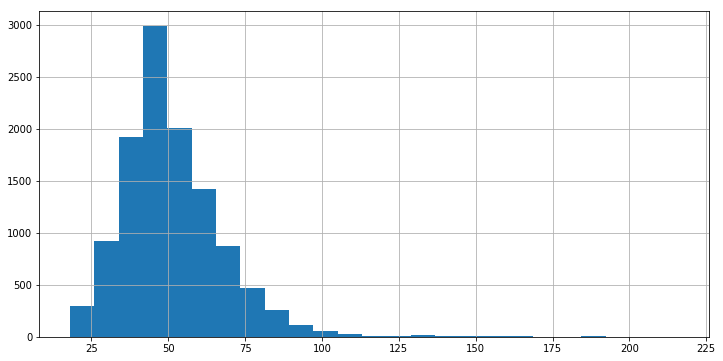

In [64]:
lens.hist(figsize=(12, 6), bins=25);

Reviews with more than 5000 characters are dropped

In [14]:
long_reviews = neg.loc[neg['text'].str.len() > 5000].index
neg.drop(long_reviews, inplace=True)

Mean, standard deviation and max length of positive reviews

In [66]:
lens = pos['newsHeadline'].str.len()
lens.mean(), lens.std(), lens.max()

(51.16122514950703, 16.68625326168023, 271)

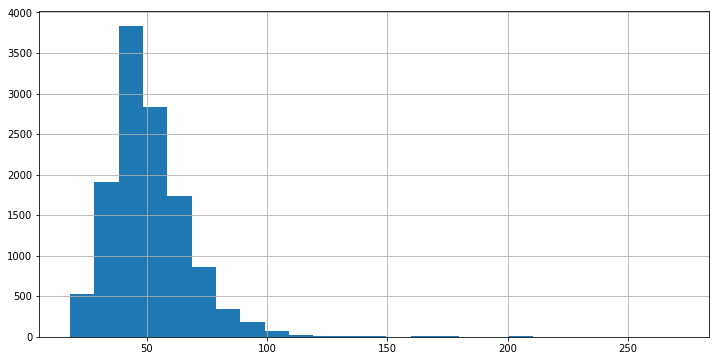

In [67]:
lens.hist(figsize=(12, 6), bins=25);

In [17]:
long_reviews = pos.loc[pos['text'].str.len() > 5000].index
pos.drop(long_reviews, inplace=True)

Is desirable to have a balanced dataset (similar quantity of positive and negative instances). So we will pick a random subset of the positive instances.

In [68]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

In [69]:
neg.shape, pos.shape

((11427, 2), (11427, 2))

We concatenate positive and negative reviews

In [70]:
df = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)
df.head()

,newsHeadline,class
0,Unfair to knock Apple Beats: Cramer,1.0
1,FBI director slams Google Apple,1.0
2,Apple s Fourth Generation iPad Replaces iPad 2,1.0
3,Apple iPhone 6: First leaked images surface on...,1.0
4,Apple Antitrust Cooperation Has Declined,0.0


In [71]:
df.shape

(22854, 2)

Split data into train and test set

In [72]:
X_train, X_test, y_train, y_test = train_test_split(df['newsHeadline'].values, df['class'].values, test_size=0.2, random_state=42)

In [73]:
len(X_train), len(X_test), len(y_train), len(y_test)

(18283, 4571, 18283, 4571)

Defining tokenizer

In [74]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Creating bag of words

In [75]:
vect = CountVectorizer(tokenizer=tokenize)

In [76]:
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

Train term frequency contains 32675 documents and 45424 tokens. Each row represents a document and each column how many times that token appears on the document.

In [77]:
tf_train

<18283x9884 sparse matrix of type '<class 'numpy.int64'>'
	with 178766 stored elements in Compressed Sparse Row format>

For instance, the first document have just 65 of the 45424 possible tokens. That's why the matrix is stored as a sparse matrix.

In [78]:
tf_train[0]

<1x9884 sparse matrix of type '<class 'numpy.int64'>'
	with 13 stored elements in Compressed Sparse Row format>

Get vocabulary

In [79]:
vocab = vect.get_feature_names()
len(vocab)

9884

In [80]:
vocab[4000: 4005]

['gobbles', 'god', 'godaddy', 'goes', 'goggles']

In [81]:
X_train[0]

'Apple?s growth streak fading | Profit @ $11.2bn'

First review's tokens

In [82]:
w0 = set([o for o in X_train[0].split(' ')])

In [83]:
w0

{'$11.2bn', '@', 'Apple?s', 'Profit', 'fading', 'growth', 'streak', '|'}

In [85]:
vect.vocabulary_['growth']

4101

In [87]:
tf_train[0, 4101]

1

### Multinomial Naive Bayes

Here we reduce our training data to 2 dimentions (using TruncatedSVD rather than PCA because we are working with sparse matrices) and then we plot it in order to  roughly see how classes are separated

In [88]:
svd = TruncatedSVD()
reduced_tf_train = svd.fit_transform(tf_train)

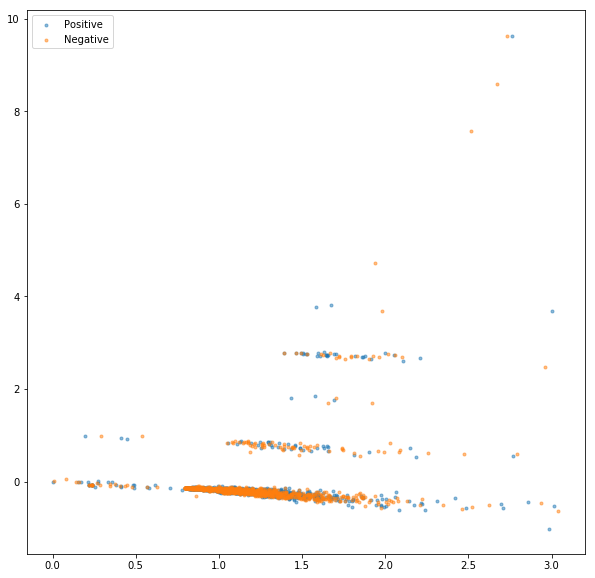

In [89]:
plot_embeddings(reduced_tf_train, y_train)

First attempt is to use a simple Multinomial Naive Bayes

In [90]:
p = tf_train[y_train==1].sum(0) + 1
q = tf_train[y_train==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [91]:
pre_preds = tf_test @ r.T + b
preds = pre_preds.T > 0
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.6525924305403632


Rather than use r coefficients that we get trough Naive Bayes, let's learn them from data using Logistic Regression

In [92]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.6453730037190987


F:\Documents\CPSC 571 Project\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


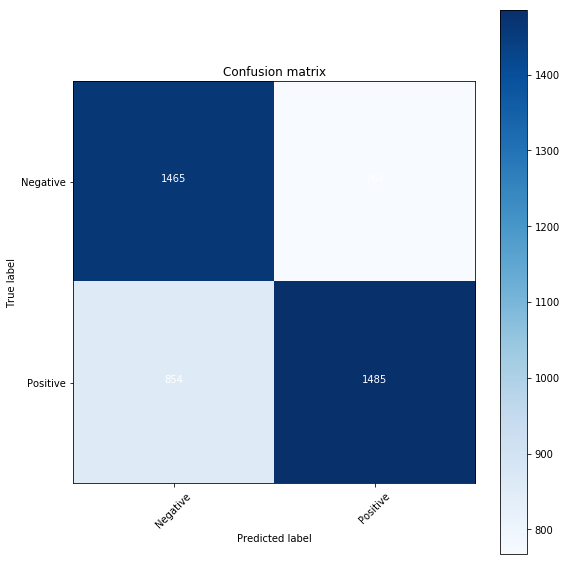

In [93]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

Let's plot most relevant words that the algorithm uses to classify a text in positive or negative

In [94]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':model.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

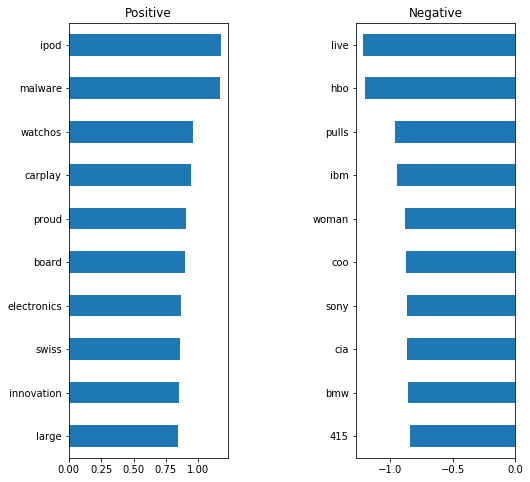

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

Removing 'ea' token

In [44]:
vect.vocabulary_['ea']

12893

In [45]:
tf_train = lil2(tf_train)
tf_train.removecol(12893)

In [48]:
tf_test = lil2(tf_test)
tf_test.removecol(12893)

In [96]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train, y_train)
preds = model.predict(tf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.6453730037190987


F:\Documents\CPSC 571 Project\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's try now with bigram tf-idf rather than unigram tf

In [97]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)

In [98]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

Division between classes is more clear now

In [99]:
svd = TruncatedSVD()
reduced_tfidf_train = svd.fit_transform(tfidf_train)

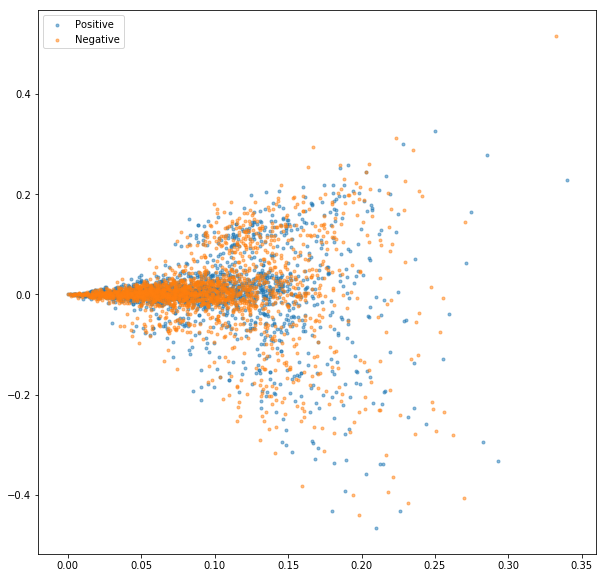

In [100]:
plot_embeddings(reduced_tfidf_train, y_train, 2000)

In [101]:
p = tfidf_train[y_train==1].sum(0) + 1
q = tfidf_train[y_train==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [103]:
model = LogisticRegression(C=30, dual=True, max_iter=2000)
model.fit(tfidf_train, y_train)
preds = model.predict(tfidf_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

F:\Documents\CPSC 571 Project\venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.6766571866112449


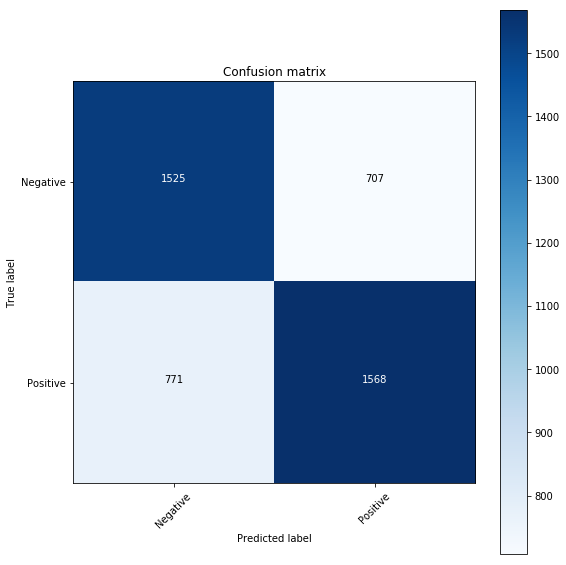

In [104]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

### CNN

We will try now with a simple Convolutional Neural Network

In [67]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input, concatenate
from keras.optimizers import Adam

/home/martinpella/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tokenize reviews

In [68]:
df['tokenized'] = df['text'].apply(tokenize)

Get vocabulary

In [69]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [70]:
vocab_counter = collections.Counter()
df['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [71]:
len(vocab)

49981

Word to index dictionary

In [73]:
w2id = {w:i for i, w in enumerate(vocab)}

Words to index transformation

In [74]:
def transform_to_ids(row):
    return [w2id[w] for w in row]

In [75]:
df['tokenized'] = df['tokenized'].apply(lambda x: transform_to_ids(x))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df['tokenized'].values, df['class'].values, test_size=0.2, random_state=42)

In [77]:
maxlen = 1000

All the inputs to the conv net must have a fixed size. We set 1000 as the max length and we fill with -1 all reviews smaller than 1000.

In [78]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=-1)
x_test = pad_sequences(X_test, maxlen=maxlen, value=-1)

In [1]:
model = Sequential([Embedding(input_dim=len(vocab), output_dim=32, input_length=maxlen),
                    SpatialDropout1D(0.2),
                    Dropout(0.25),
                    Convolution1D(64, 5, padding='same', activation='relu'),
                    Dropout(0.25),
                    MaxPooling1D(),
                    Flatten(),
                    Dense(100, activation='relu'),
                    Dropout(0.85),
                    Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

NameError: name 'Sequential' is not defined

In [92]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=4, batch_size=64)

Train on 32670 samples, validate on 8168 samples
Epoch 1/4
32670/32670 [==============================] - 8s - loss: 0.4518 - acc: 0.7556 - val_loss: 0.1932 - val_acc: 0.9247
Epoch 2/4
32670/32670 [==============================] - 8s - loss: 0.1879 - acc: 0.9352 - val_loss: 0.1781 - val_acc: 0.9344
Epoch 3/4
32670/32670 [==============================] - 8s - loss: 0.1323 - acc: 0.9557 - val_loss: 0.1965 - val_acc: 0.9345
Epoch 4/4
32670/32670 [==============================] - 8s - loss: 0.1015 - acc: 0.9672 - val_loss: 0.2129 - val_acc: 0.9327


Maybe finding best hyperparameters could lead to a better accuracy, but this more complex model is not better than our linear classifier.